In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import re
import nltk
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random
import torch.nn.functional as F
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def convert_to_lowercase(text):
    return text.lower()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def map_stars_to_sentiment(stars):
    if stars > 3:
        return 'positive'
    elif stars <= 2:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Yelp review dataset
train_data = pd.read_csv('/content/drive/MyDrive/yelp_review_train.csv')  # Replace with your actual file path
test_data = pd.read_csv('/content/drive/MyDrive/yelp_review_test.csv')


In [ ]:
print(train_data.head)

<bound method NDFrame.head of                                                      text  stars
0       Went for lunch and found that my burger was me...    2.0
1       I needed a new tires for my wife's car. They h...    5.0
2       Jim Woltman who works at Goleta Honda is 5 sta...    5.0
3       Been here a few times to get some shrimp.  The...    4.0
4       This is one fantastic place to eat whether you...    5.0
...                                                   ...    ...
174752  Oy. Not great, partially my fault but holy smo...    2.0
174753  I'm a huge fan of Chocolate Maya! High quality...    5.0
174754  Hosted our Wedding Ceremony here and could hav...    5.0
174755  I love this place!!! They have fantastic lunch...    5.0
174756  So happy with the service and food. One of the...    5.0

[174757 rows x 2 columns]>


In [ ]:
train_data['text'] = train_data['text'].apply(remove_punctuation)
train_data['text'] = train_data['text'].apply(convert_to_lowercase)
train_data['text'] = train_data['text'].apply(remove_stopwords)
train_data['sentiment'] = train_data['stars'].apply(map_stars_to_sentiment)

In [ ]:
test_data['text'] = test_data['text'].apply(remove_punctuation)
test_data['text'] = test_data['text'].apply(convert_to_lowercase)
test_data['text'] = test_data['text'].apply(remove_stopwords)
test_data['sentiment'] = test_data['stars'].apply(map_stars_to_sentiment)

In [ ]:
print(test_data.head())

                                                text  stars sentiment
0  hidden treasure awesome service delicious food...    5.0  positive
1  family patients since 5 years old 34 trust qua...    5.0  positive
2  rarely get pedicures blue nails practice combi...    5.0  positive
3  came large group may items missing menu lobste...    2.0  negative
4  view great morgans pier bartenders even good s...    2.0  negative


In [ ]:
print(train_data.head())

                                                text  stars sentiment
0  went lunch found burger meh obvious focus burg...    2.0  negative
1  needed new tires wifes car special order next ...    5.0  positive
2  jim woltman works goleta honda 5 stars knowled...    5.0  positive
3  times get shrimp theyve got nice selection dif...    4.0  positive
4  one fantastic place eat whether hungry need go...    5.0  positive


In [ ]:
texts = train_data['text'].tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1


In [ ]:
max_seq_length = 100
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [ ]:
sentiment_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
train_data['sentiment_label'] = train_data['sentiment'].map(sentiment_mapping)

In [ ]:
test_texts = test_data['text'].tolist()
test_tokenizer = Tokenizer()
test_tokenizer.fit_on_texts(test_texts)
test_vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_seq_length = 100
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [ ]:
test_data['sentiment_label'] = test_data['sentiment'].map(sentiment_mapping)

In [ ]:
print(train_data.head)

<bound method NDFrame.head of                                                      text  stars sentiment  \
0       went lunch found burger meh obvious focus burg...    2.0  negative   
1       needed new tires wifes car special order next ...    5.0  positive   
2       jim woltman works goleta honda 5 stars knowled...    5.0  positive   
3       times get shrimp theyve got nice selection dif...    4.0  positive   
4       one fantastic place eat whether hungry need go...    5.0  positive   
...                                                   ...    ...       ...   
174752  oy great partially fault holy smokes daughter ...    2.0  negative   
174753  im huge fan chocolate maya high quality ingred...    5.0  positive   
174754  hosted wedding ceremony could happier everythi...    5.0  positive   
174755  love place fantastic lunch specials get 3 roll...    5.0  positive   
174756  happy service food one best tasting turkey bur...    5.0  positive   

        sentiment_label  
0      

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask):
        # Getting the number of training examples
        batch_size = query.shape[0]

        # Performing linear transformation and split into heads
        Q = self.query(query).view(batch_size, -1, self.n_heads, self.head_dim)
        K = self.key(key).view(batch_size, -1, self.n_heads, self.head_dim)
        V = self.value(value).view(batch_size, -1, self.n_heads, self.head_dim)

        # Transposing to get dimensions [batch_size, n_heads, seq_len, head_dim]
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        # Calculating attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

        # Applying mask to prevent attention to padded tokens
        scores = scores.masked_fill(mask == 0, float('-inf'))

        # Applying softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)

        # Applying attention weights to value
        output = torch.matmul(attention_weights, V)

        # Transposing to get dimensions [batch_size, seq_len, n_heads, head_dim]
        output = output.transpose(1, 2).contiguous()

        # Reshaping to get dimensions [batch_size, seq_len, d_model]
        output = output.view(batch_size, -1, self.d_model)

        # Applying linear layer
        output = self.fc_out(output)

        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, num_layers, max_len, output_dim):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead=n_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x, mask):
        x = self.embedding(x)
        x = x + self.positional_encoding(x)
        key_padding_mask = (x.sum(dim=-1) == 0).transpose(0, 1)  # 2D key_padding_mask

        x = self.transformer_encoder(x, src_key_padding_mask=key_padding_mask)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [ ]:
# Transformer Model Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
d_model = 256
n_heads = 8          # Number of attention heads
num_layers = 4       # Number of transformer layers
max_len = max_seq_length  # Maximum sequence length
output_dim = 3       # Number of output classes (positive, negative, neutral)


In [ ]:
model1 = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, train_data['sentiment_label'], test_size=0.2, random_state=42)


Epoch 1/10, Training Loss: 0.7761, Training Accuracy: 0.6902, Validation Accuracy: 0.7565
Epoch 2/10, Training Loss: 0.6031, Training Accuracy: 0.7735, Validation Accuracy: 0.8021
Epoch 3/10, Training Loss: 0.5198, Training Accuracy: 0.8092, Validation Accuracy: 0.8247
Epoch 4/10, Training Loss: 0.4795, Training Accuracy: 0.8223, Validation Accuracy: 0.8274
Epoch 5/10, Training Loss: 0.4548, Training Accuracy: 0.8313, Validation Accuracy: 0.8346
Epoch 6/10, Training Loss: 0.4371, Training Accuracy: 0.8377, Validation Accuracy: 0.8428
Epoch 7/10, Training Loss: 0.4189, Training Accuracy: 0.8433, Validation Accuracy: 0.8407
Epoch 8/10, Training Loss: 0.4074, Training Accuracy: 0.8485, Validation Accuracy: 0.8454
Epoch 9/10, Training Loss: 0.3974, Training Accuracy: 0.8512, Validation Accuracy: 0.8404
Epoch 10/10, Training Loss: 0.3899, Training Accuracy: 0.8536, Validation Accuracy: 0.8492


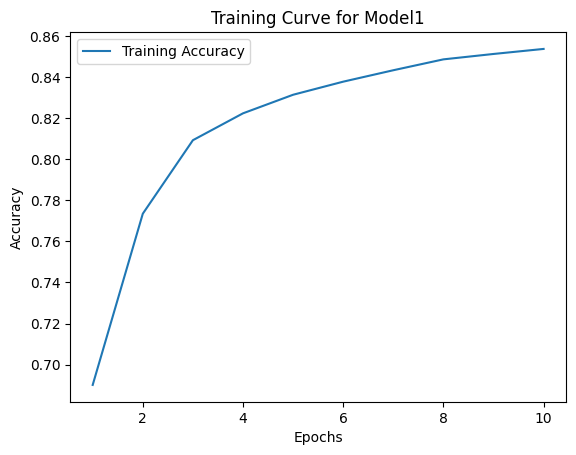

In [ ]:
# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Creating DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Transformer model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
best_val_accuracy = 0.0
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X, mask=(batch_X != 0))
        outputs = outputs.to(device)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # training accuracy
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == batch_y).sum().item()
        total_samples += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X, mask=(val_X != 0).to(device))
            val_predictions.extend(torch.argmax(val_outputs, dim=1).to(device).cpu().numpy())
            val_targets.extend(val_y.to(device).cpu().numpy())

    val_accuracy = accuracy_score(val_targets, val_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model if it has the highest validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Plot the training curve
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve for Model1')
plt.legend()
plt.show()


In [ ]:
X_test = test_padded_sequences
y_test = test_data['sentiment_label']

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and validation
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim).to(device)

# Load the best model saved during training
model.load_state_dict(torch.load('best_model.pth'))
# Set the model to evaluation mode
model.eval()

# Define the loss function (if needed)
criterion = nn.CrossEntropyLoss()

# Evaluate the model on the test set
correct_predictions = 0
total_samples = 0

test_predictions = []
test_targets = []

with torch.no_grad():
    for test_X, test_y in test_loader:
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_outputs = model(test_X, mask=(test_X != 0))
        test_predictions.extend(torch.argmax(test_outputs, dim=1).to(device).cpu().numpy())
        test_targets.extend(test_y.to(device).cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_predictions)

print("Model1 Test Accuracy:{}".format(test_accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model1 Test Accuracy:0.8510729613733906


In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(test_targets, test_predictions)

print("Model1 Confusion Matrix:")
print(conf_matrix)

# classification report
print("\n Model1 Classification Report:")
print(classification_report(test_targets, test_predictions))

Model1 Confusion Matrix:
[[9051  243  125]
 [ 424 2596  125]
 [ 777  388  251]]

 Model1 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      9419
           1       0.80      0.83      0.81      3145
           2       0.50      0.18      0.26      1416

    accuracy                           0.85     13980
   macro avg       0.73      0.65      0.67     13980
weighted avg       0.83      0.85      0.83     13980



In [ ]:
# Transformer Model Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
d_model = 128
n_heads = 4          # Number of attention heads
num_layers = 3       # Number of transformer layers
max_len = max_seq_length  # Maximum sequence length
output_dim = 3       # Number of output classes (positive, negative, neutral)


In [ ]:
model2 = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Training Loss: 0.7801, Training Accuracy: 0.6884, Validation Accuracy: 0.7077
Epoch 2/10, Training Loss: 0.6473, Training Accuracy: 0.7525, Validation Accuracy: 0.7828
Epoch 3/10, Training Loss: 0.5551, Training Accuracy: 0.7945, Validation Accuracy: 0.8107
Epoch 4/10, Training Loss: 0.5104, Training Accuracy: 0.8120, Validation Accuracy: 0.8150
Epoch 5/10, Training Loss: 0.4836, Training Accuracy: 0.8209, Validation Accuracy: 0.8278
Epoch 6/10, Training Loss: 0.4652, Training Accuracy: 0.8272, Validation Accuracy: 0.8316
Epoch 7/10, Training Loss: 0.4486, Training Accuracy: 0.8345, Validation Accuracy: 0.8292
Epoch 8/10, Training Loss: 0.4376, Training Accuracy: 0.8381, Validation Accuracy: 0.8380
Epoch 9/10, Training Loss: 0.4268, Training Accuracy: 0.8416, Validation Accuracy: 0.8413
Epoch 10/10, Training Loss: 0.4169, Training Accuracy: 0.8443, Validation Accuracy: 0.8454


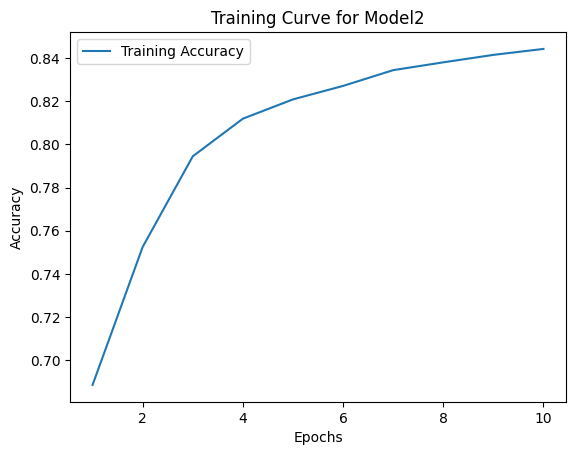

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# DataLoader for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the Transformer model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
best_val_accuracy = 0.0
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X, mask=(batch_X != 0))
        outputs = outputs.to(device)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # training accuracy
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == batch_y).sum().item()
        total_samples += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X, mask=(val_X != 0).to(device))
            val_predictions.extend(torch.argmax(val_outputs, dim=1).to(device).cpu().numpy())
            val_targets.extend(val_y.to(device).cpu().numpy())

    val_accuracy = accuracy_score(val_targets, val_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model if it has the highest validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Plot the training curve
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve for Model2')
plt.legend()
plt.show()


In [ ]:
X_test = test_padded_sequences
y_test = test_data['sentiment_label']

X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# DataLoader for training and validation
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = TransformerModel(vocab_size, d_model, n_heads, num_layers, max_len, output_dim).to(device)

# best model saved during training
model.load_state_dict(torch.load('best_model.pth'))  # Replace with the actual path

# evaluation mode
model.eval()

# loss function
criterion = nn.CrossEntropyLoss()

# Evaluating the model on the test set
correct_predictions = 0
total_samples = 0

test_predictions = []
test_targets = []

with torch.no_grad():
    for test_X, test_y in test_loader:
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_outputs = model(test_X, mask=(test_X != 0))
        test_predictions.extend(torch.argmax(test_outputs, dim=1).to(device).cpu().numpy())
        test_targets.extend(test_y.to(device).cpu().numpy())

    test_accuracy = accuracy_score(test_targets, test_predictions)

print("Model2 Test Accuracy:{}".format(test_accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model2 Test Accuracy:0.8471387696709585


In [ ]:
# confusion matrix
conf_matrix = confusion_matrix(test_targets, test_predictions)


print("Model2 Confusion Matrix:")
print(conf_matrix)

# classification report
print("\n Model2 Classification Report:")
print(classification_report(test_targets, test_predictions))

Model2 Confusion Matrix:
[[9067  274   78]
 [ 442 2624   79]
 [ 839  425  152]]

 Model2 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      9419
           1       0.79      0.83      0.81      3145
           2       0.49      0.11      0.18      1416

    accuracy                           0.85     13980
   macro avg       0.72      0.63      0.63     13980
weighted avg       0.82      0.85      0.82     13980

